# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Ипортированные библиотеки за весь проект:**

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import r2_score #R2

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import RandomState

## Загрузка и подготовка данных

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_0.head()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

**Спецификация таблицы:**

* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей)

`id` для обучения не будем рассматривать. На всех остальных фичах будем обучать модели.

`product` - целевой признак

In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Проверка на дубликаты объектов

In [5]:
data_1['id'].duplicated().sum()

4

Скорее всего в таблицу вносились обновленные данные о скважине, а старые не удалялись. Нужно удалить 1 значение и оставить 2. Так же привожу выборки к одному размеру(есть большие сомнения по поводу данного шага и каким методом я это сделаю, но была не была xD

In [6]:
data_0 = data_0.drop_duplicates(subset='id', keep='last').reset_index(drop='True') #-10 объектов

data_1 = data_1.drop_duplicates(subset='id', keep='last').reset_index(drop='True') # -4
data_1= data_1[:-6]

data_2 = data_2.drop_duplicates(subset='id', keep='last').reset_index(drop='True') # -4 
data_2 = data_2[:-6]

### Разделение датасетов на признаки и целевой показатель:

In [7]:
#data_0
fetures_0 = data_0.drop(['id', 'product'], axis=1)
target_0 = data_0['product']

#dato_1
fetures_1 = data_1.drop(['id', 'product'], axis=1)
target_1 = data_1['product']

#data_2
fetures_2 = data_2.drop(['id', 'product'], axis=1)
target_2 = data_2['product']

###  Разделение на обучающую и валидационную выборки
Разбиение данных на обучающую и валидационную выборки в соотношении **75:25**

In [8]:
RANDOM_STATE = 911

In [9]:
#data_0
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(fetures_0, target_0,test_size=0.25,
                                                                                      random_state=RANDOM_STATE)
#data_1
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(fetures_1, target_1, test_size=0.25,
                                                                                      random_state=RANDOM_STATE)
#data_2
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(fetures_2, target_2, test_size=0.25,
                                                                                      random_state=RANDOM_STATE)

### Стандартизация фичей
Все фичи нужно масштабировать в каждой таблице, обучение алгоритма шифрования на созданных выборках, апотом трансформировать

In [10]:
features_train_0.head()

f0        f1        f2
26404 -0.178191  1.020335  6.633897
59499  0.551908 -0.066742  1.334648
26985 -0.138006  1.072542  3.270146
39509  1.432500 -0.439947  0.929117
73047  0.902554  0.271999  0.858458

In [11]:
numeric = ['f0', 'f1', 'f2']

#устранение конфликта sklearn и pandas
pd.options.mode.chained_assignment = None

#0
scaler_0 = StandardScaler()
scaler_0.fit(features_train_0[numeric], features_valid_0[numeric])

features_train_0[numeric] = scaler_0.transform(features_train_0[numeric])
features_valid_0[numeric] = scaler_0.transform(features_valid_0[numeric])

#1
scaler_1 = StandardScaler()
scaler_1.fit(features_train_1[numeric], features_valid_1[numeric])

features_train_1[numeric] = scaler_1.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler_1.transform(features_valid_1[numeric])

#2
scaler_2 = StandardScaler()
scaler_2.fit(features_train_2[numeric], features_valid_2[numeric])

features_train_2[numeric] = scaler_2.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler_2.transform(features_valid_2[numeric])

In [12]:
features_train_0.head()

f0        f1        f2
26404 -0.773139  1.526597  1.269426
59499  0.062506 -0.629548 -0.359413
26985 -0.727144  1.630146  0.235504
39509  1.070400 -1.369775 -0.484062
73047  0.463844  0.042322 -0.505781

План действий нужно было обозначить раньше, но там ты он потерялся поэтому в конце 1 пункта

**поясненить порядок действий:** 
- проверка данных и подготовка к обработке; 
- разбитие датасета на признаки и целевые показатели; 
- разделение на обучающую и вариационные выборки;
- масштабировать необходимые численные признаки; 
- выбор алгоритма линейной регрессии;
- обучение каждой группы по отдельности.

## Обучение и проверка модели

### LinearRegression

In [13]:
#обучение модели 0
model = LinearRegression()
model.fit(features_train_0, target_train_0)
valid_predict_0 = model.predict(features_valid_0)

mae = mean_absolute_error(target_valid_0, valid_predict_0)
mse = mean_squared_error(target_valid_0, valid_predict_0)
#проверка модели
rmse_line_0 = mse**0.5 
target_valid_mean_0 = target_valid_0.mean()

#качество модели
print('data_0:\nr2 на обучающей выборке:', model.score(features_train_0, target_train_0))
print('r2 на валидационной выборке:', r2_score(target_valid_0, valid_predict_0))
print('')
print('Cредний запас предсказываемого сырья:', target_valid_mean_0)
print('RMSE:', rmse_line_0)

#сохранение в одной таблице таргеты и предсказания
predict_target_valid_0 = pd.DataFrame({'target': target_valid_0, 'predict': valid_predict_0})
predict_target_valid_0.head()

data_0:
r2 на обучающей выборке: 0.2757744597749967
r2 на валидационной выборке: 0.27540051525088327

Cредний запас предсказываемого сырья: 92.84761656832517
RMSE: 37.729490270433594


target     predict
15975  127.187946   88.019356
20401  136.370360   55.320294
2402   159.701133  115.510968
96961  127.758230   80.012533
7120    56.233577   92.491457

У данной модели переобучение отсутсвует, правда хотелось бы чуть более высокую точность предсказания, но если рассматривать другие типы моделей то происходит переобучение. Погрешность ниже среднего значения - все ок 

In [14]:
#1
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
valid_predict_1 = model_1.predict(features_valid_1)

mae = mean_absolute_error(target_valid_1, valid_predict_1)
mse = mean_squared_error(target_valid_1, valid_predict_1)

#качество модели
print('data_1:\nr2 на обучающей выборке:', model_1.score(features_train_1, target_train_1))
print('r2 на валидационной выборке:', r2_score(target_valid_1, valid_predict_1))
print('')
#проверка модели
rmse_line_1 = mse**0.5 
target_valid_mean_1 = target_valid_1.mean()
print('Cредний запас предсказываемого сырья:', target_valid_mean_1)
print('RMSE:', rmse_line_1)

#сохранение в одной таблице таргеты и предсказания
predict_target_valid_1 = pd.DataFrame({'target': target_valid_1, 'predict': valid_predict_1})
predict_target_valid_1.head()

data_1:
r2 на обучающей выборке: 0.9996238276698497
r2 на валидационной выборке: 0.999626070948368

Cредний запас предсказываемого сырья: 69.12791178188684
RMSE: 0.8873007517583831


target     predict
15975   57.085625   58.247776
20401   84.038886   84.100161
2402   110.992147  110.468802
96961  110.992147  110.172970
7120    84.038886   83.607533

Так – так, а тут уже совершенно другие цифры постараюсь это обосновать. 

В фичах содержится большое количество повторений, поэтому модель так хорошо обучилась и вызубрила все варианты ответов. Но при всем при этом переобучения модели не произошло. 

In [15]:
#2
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
valid_predict_2 = model_2.predict(features_valid_2)

mae = mean_absolute_error(target_valid_2, valid_predict_2)
mse = mean_squared_error(target_valid_2, valid_predict_2)

#качество модели
print('data_2:\nr2 на обучающей выборке:', model_2.score(features_train_2, target_train_2))
print('r2 на валидационной выборке:', r2_score(target_valid_2, valid_predict_2))
print('')
#проверка модели
rmse_line_2 = mse**0.5 
target_valid_mean_2 = target_valid_2.mean()
print('Cредний запас предсказываемого сырья:', target_valid_mean_2)
print('RMSE:', rmse_line_2)

#сохранение в одной таблице таргеты и предсказания
predict_target_valid_2 = pd.DataFrame({'target': target_valid_2, 'predict': valid_predict_2})
predict_target_valid_2.head()

data_2:
r2 на обучающей выборке: 0.19858844011923482
r2 на валидационной выборке: 0.19935560112237227

Cредний запас предсказываемого сырья: 94.71015724780415
RMSE: 39.949423885557536


target    predict
15975  113.130804  99.121338
20401   82.821624  92.737244
2402   121.203292  95.345476
96961   80.030365  46.067469
7120    49.612682  87.196551

Тут дата сет совпадает с «0» поэтому результаты одинаковые.  

**Собранные данные по всем регионам:**

In [16]:
#предсказания моделей и тагреты
predict_target_valid_0
predict_target_valid_1
predict_target_valid_2

print ('Регион 0:  ', '%.2f, %.2f' % (target_valid_mean_0, rmse_line_0))
print ('Регион 1:  ', '%.2f, %.2f' % (target_valid_mean_1, rmse_line_1))
print ('Регион 2:  ', '%.2f, %.2f' % (target_valid_mean_2, rmse_line_2))

Регион 0:   92.85, 37.73
Регион 1:   69.13, 0.89
Регион 2:   94.71, 39.95


**Вывод:** Обучены модели линейной регрессии. Предсказания 0 и 2 модели выглядят реальными и походи на правду, правда хотелось бы лучше и более точно обучить чтобы качество предсказаний было выше, но не вышло иначе происходит переобучение, если рассматривать другие другие модели регрессий. Предсказания Модели 1 вышли самые точные, по той причине, что таблица содержит в себе больше количество дубликатов, думаю этот результат можно считать не шибко правдоподобным и адекватным из-за большого количества повторений хотя с поставленной целью она справилась и сделала качественный прогноз. 

## Подготовка к расчёту прибыли
### Все ключевые значения для расчётов

In [17]:
BUDGET = 10_000_000_000 #бюджет
BARE = 450_000 #стоимость 1 bare
profit = 0
BEST_DEVELOPMENT = 200 #лучшие объекты для исследования
POINT_SELECTION = 500 #отбор точек

In [18]:
#средняя прибыль точки:
profit_mean_point = BUDGET / BEST_DEVELOPMENT
print ('средняя прибыль скважины:', profit_mean_point, 'руб.')

#средняя добыча точки в бар:
profit_mean_bare = profit_mean_point / BARE
print('среднее кол-во нефти с одной скважины:', '%.1f' % profit_mean_bare, 'тыс. баррелей')

#средняя добыча в регионе в бар:
mean_bare = BUDGET / BARE
print('среднее кол-во нефти на регион:', '%.1f' % mean_bare, 'тыс. баррелей')

средняя прибыль скважины: 50000000.0 руб.
среднее кол-во нефти с одной скважины: 111.1 тыс. баррелей
среднее кол-во нефти на регион: 22222.2 тыс. баррелей


In [19]:
print ('Средняя добыча по регионам:')
print ('Регион 0:  ', '%.2f' % (data_0['product'].mean()))
print ('Регион 1:  ', '%.2f' % (data_1['product'].mean()))
print ('Регион 2:  ', '%.2f' % (data_2['product'].mean()))

Средняя добыча по регионам:
Регион 0:   92.50
Регион 1:   68.83
Регион 2:   95.00


### Визуализация прибыли

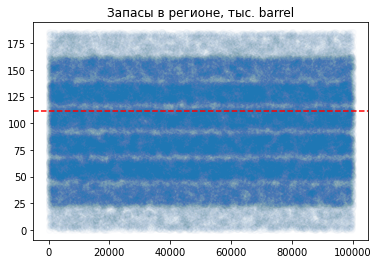

In [20]:
data_0['product'].plot(style='o', alpha=.01, title='Запасы в регионе, тыс. barrel')
plt.axhline(profit_mean_bare, color='r', linestyle='--')

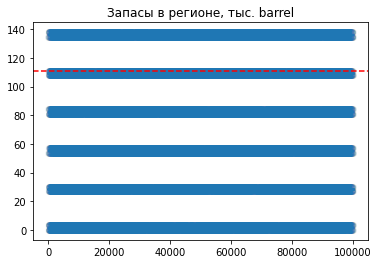

In [21]:
data_1['product'].plot(style='o', alpha=.01, title='Запасы в регионе, тыс. barrel')
plt.axhline(profit_mean_bare, color='r', linestyle='--')

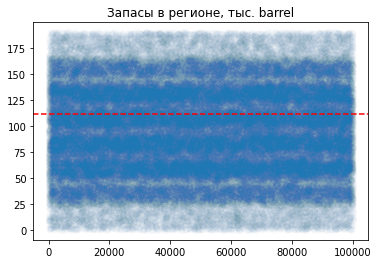

In [22]:
data_2['product'].plot(style='o', alpha=.01, title='Запасы в регионе, тыс. barrel')
plt.axhline(profit_mean_bare, color='r', linestyle='--')

**Вывод** Скважина должна приносить 50 млн. чтобы она была без убыточна, если переводить на кол-во нефти от 111,1 тыс. баррелей должна добывать скважина. 

Средний объем для добычи в регионах оказался ниже безубыточного уровня, но это не так страшно выбрать есть из чего особенно, в регионе 0 и 2. А вот в 1 регионе это уже сложнее сделать, но все равно безубыточные скважины есть, хоть и не так много. 

## Расчёт прибыли и рисков 

### Функция расчета прибыли:

In [24]:
#прибыль
def profit(target, predict,  count):
    predict_sorted = predict.sort_values(ascending=False)
    select = target[predict_sorted.index][:count]
    return BARE * select.sum() - BUDGET

#проверка
#profit(predict_target_valid_0['target'], , 200)

### Bootstrap

In [25]:
POINT_SELECTION = 500 #точек 

In [26]:
state = RandomState(992)

def bootstraptor(target, predict):
    #сохраняем походящие объекты
    values = []
    for i in range(1000):
        subsample = target.sample(POINT_SELECTION, random_state=state, replace=True)
        predict_subsample = predict[subsample.index]
        profit_subsample = profit(target, predict_subsample, BEST_DEVELOPMENT)
        values.append(profit_subsample)
    
    #перевод списка в таблицу
    data_values = pd.DataFrame({'values':values})
    
    #колличество убыточных скважен  
    loss = (data_values < 0).sum()
    

    values_mean = np.mean(values)
    lower = np.percentile(values, 2.5)
    upper = np.percentile(values, 97.5)
    print('Средняя прибыль:','%.0f'%values_mean)
    print('Доверительный интервал (95%):', '%.0f, %.0f' % (lower, upper))
    print('Вероятность убытка, %:',(loss / 1000)*100)

**Регион 0**

In [27]:
bootstraptor(predict_target_valid_0['target'], predict_target_valid_0['predict'])

Средняя прибыль: 454434126
Доверительный интервал (95%): -69953426, 958076173
Вероятность убытка, %: values    4.3
dtype: float64


**Регион 1**

In [28]:
bootstraptor(predict_target_valid_1['target'], predict_target_valid_1['predict'])

Средняя прибыль: 477660978
Доверительный интервал (95%): 49574172, 890826915
Вероятность убытка, %: values    1.8
dtype: float64


**Регион 2**

In [29]:
bootstraptor(predict_target_valid_2['target'], predict_target_valid_2['predict'])

Средняя прибыль: 317677762
Доверительный интервал (95%): -237829743, 855848904
Вероятность убытка, %: values    11.9
dtype: float64


**Вывод:** Из всех рассмотренных регионов стоит остановить свое внимание на **1**, т.к. вероятность убытка выше на 2.2 % чем у 0 региона, но при этом диапазон доверительного интервала в 2-3 раза. Т.Е. если убыток будет всё-таки получен его размер будет гораздо меньше. Конечно, нужно думать о прибыли, но в данной ситуации надо рассматривать варианты от наихудшего стечения обстоятельств. По поводу 2 региона вероятность получения убытка самая большая, да и его размер может составить очень приличную – самый рисковый вариант. **Самый оптимальным регионом для разработки месторождений является 1.**

Прогноз удивил я думал будет совершенно иначе.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован